In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt

print(torch.__version__)
print('Cuda Available : {}'.format(torch.cuda.is_available()))
if torch.cuda.is_available():
  print('GPU - {0}'.format(torch.cuda.get_device_name()))

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

2.2.2
Cuda Available : False


## LOAD & PRE-PROCESSING DATASET



In [2]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to tensor
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize the pixel values
])

# Load MNIST training dataset with transformations
mnist_train = datasets.MNIST('data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST('data', train=False, download=True, transform=transform)

# Define data loaders
train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=128)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [03:03<00:00, 54091.17it/s] 


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 63375.31it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:09<00:00, 168286.86it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1568848.62it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## Applying Dropout to the dense layers in a CNN 

In [61]:
print('train size', len(mnist_train))
print('test size', len(mnist_test))

train size 48000
test size 10000


In [103]:
class CNN_dropout(nn.Module):
    def __init__(self):
        super(CNN_dropout, self).__init__()
        
        #convolutional layer
        self.cnn_layers = nn.Sequential(
          nn.Conv2d(in_channels=1,out_channels=4,kernel_size=3, stride = 1), 
          nn.ReLU(), 
          nn.MaxPool2d(kernel_size = 2)
          )

        #dense_layer
        self.dense_layers = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(in_features = 4 * 13 * 13, out_features = 50),
            nn.Dropout(p=0.4), #Place after the dense layer we want to apply dropout to
            nn.Linear(in_features = 50, out_features = 10)
            )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.dense_layers(x)
        out = torch.softmax(x, dim=1)
        return out

In [104]:
def train(net, train_data):
  # Hyperparameters
  num_epochs = 15
  learning_rate = 0.1

  # Loss and optimizer
  optimizer = optim.SGD(net.parameters(), lr = learning_rate)
  loss_func = nn.CrossEntropyLoss()

  # Train the model
  train_acc = []
  net.train()

  dataloader = DataLoader(train_data, batch_size=128, shuffle=True)
  for epoch in range(num_epochs):

    # Extracting mini-batch
    for i, (images, labels) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}")):
      # Put data and model on the same device
      images, labels, net = images.to(device), labels.to(device), net.to(device)

      # Forward pass
      optimizer.zero_grad()
      out = net.forward(images)
      loss = loss_func(out, labels)

      # Backward and optimize
      loss.backward() #calculate the gradients of the loss
      optimizer.step() #do an optimisation step

    acc = test(net, train_data)
    train_acc.append(float(acc))
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {acc:.2f}%')
  return train_acc
  
def test(net, test_data):
  dataloader = DataLoader(test_data, batch_size=128, shuffle=False)
  with torch.no_grad():
    net.eval()
    class_predictions = []
    class_labels = []
    for (images, labels) in dataloader: #go through the test set
      images = images.to(device)

      curr_pred = torch.max(net.forward(images), 1)[1].cpu() #index of largest value

      class_predictions.append(curr_pred)
      class_labels.append(labels)

    #concatenate all tensors in the lists:
    class_predictions = torch.cat(class_predictions)
    class_labels = torch.cat(class_labels)

    correct = (class_predictions == class_labels).sum().float()
    total = len(class_predictions)

    test_accuracy = correct * 100 / total
    return test_accuracy


In [106]:
#Training with dropout 
cnn_dropout = CNN_dropout()
train_acc_cnn_do = train(cnn_dropout, mnist_train)

Epoch 1: 100%|██████████| 375/375 [00:08<00:00, 42.38it/s]


Epoch [1/15], Train Accuracy: 89.06%


Epoch 2: 100%|██████████| 375/375 [00:09<00:00, 38.48it/s]


Epoch [2/15], Train Accuracy: 90.84%


Epoch 3: 100%|██████████| 375/375 [00:10<00:00, 37.19it/s]


Epoch [3/15], Train Accuracy: 91.14%


Epoch 4: 100%|██████████| 375/375 [00:08<00:00, 42.37it/s]


Epoch [4/15], Train Accuracy: 91.61%


Epoch 5: 100%|██████████| 375/375 [00:08<00:00, 41.74it/s]


Epoch [5/15], Train Accuracy: 91.71%


Epoch 6: 100%|██████████| 375/375 [00:10<00:00, 37.11it/s]


Epoch [6/15], Train Accuracy: 91.97%


Epoch 7: 100%|██████████| 375/375 [00:09<00:00, 39.48it/s]


Epoch [7/15], Train Accuracy: 91.96%


Epoch 8: 100%|██████████| 375/375 [00:09<00:00, 40.62it/s]


Epoch [8/15], Train Accuracy: 92.40%


Epoch 9: 100%|██████████| 375/375 [00:08<00:00, 43.59it/s]


Epoch [9/15], Train Accuracy: 92.41%


Epoch 10: 100%|██████████| 375/375 [00:08<00:00, 43.02it/s]


Epoch [10/15], Train Accuracy: 92.33%


Epoch 11: 100%|██████████| 375/375 [00:10<00:00, 37.25it/s]


Epoch [11/15], Train Accuracy: 92.28%


Epoch 12: 100%|██████████| 375/375 [00:09<00:00, 41.63it/s]


Epoch [12/15], Train Accuracy: 93.14%


Epoch 13: 100%|██████████| 375/375 [00:08<00:00, 46.17it/s]


Epoch [13/15], Train Accuracy: 93.44%


Epoch 14: 100%|██████████| 375/375 [00:09<00:00, 40.97it/s]


Epoch [14/15], Train Accuracy: 93.42%


Epoch 15: 100%|██████████| 375/375 [00:09<00:00, 38.41it/s]


Epoch [15/15], Train Accuracy: 94.31%


In [107]:
test_acc_cnn_do = test(cnn_dropout, mnist_test)

## Without Dropout in the CNN  

In [113]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        #convolutional layer
        self.cnn_layers = nn.Sequential(
          nn.Conv2d(in_channels=1,out_channels=4,kernel_size=3, stride = 1), 
          nn.ReLU(), 
          nn.MaxPool2d(kernel_size = 2)
          )

        #dense_layer
        self.dense_layers = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(in_features = 4 * 13 * 13, out_features = 50),
            nn.Linear(in_features = 50, out_features = 10)
            )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.dense_layers(x)
        out = torch.softmax(x, dim=1)
        return out

In [114]:
cnn = CNN()
train_acc_cnn = train(cnn, mnist_train)

Epoch 1: 100%|██████████| 375/375 [00:08<00:00, 44.27it/s]


Epoch [1/15], Train Accuracy: 89.93%


Epoch 2: 100%|██████████| 375/375 [00:09<00:00, 37.97it/s]


Epoch [2/15], Train Accuracy: 90.95%


Epoch 3: 100%|██████████| 375/375 [00:09<00:00, 40.24it/s]


Epoch [3/15], Train Accuracy: 91.36%


Epoch 4: 100%|██████████| 375/375 [00:09<00:00, 40.76it/s]


Epoch [4/15], Train Accuracy: 91.91%


Epoch 5: 100%|██████████| 375/375 [00:08<00:00, 42.57it/s]


Epoch [5/15], Train Accuracy: 91.99%


Epoch 6: 100%|██████████| 375/375 [00:08<00:00, 44.02it/s]


Epoch [6/15], Train Accuracy: 93.14%


Epoch 7: 100%|██████████| 375/375 [00:09<00:00, 40.57it/s]


Epoch [7/15], Train Accuracy: 93.28%


Epoch 8: 100%|██████████| 375/375 [00:09<00:00, 39.37it/s]


Epoch [8/15], Train Accuracy: 94.03%


Epoch 9: 100%|██████████| 375/375 [00:08<00:00, 42.48it/s]


Epoch [9/15], Train Accuracy: 94.51%


Epoch 10: 100%|██████████| 375/375 [00:08<00:00, 45.18it/s]


Epoch [10/15], Train Accuracy: 95.20%


Epoch 11: 100%|██████████| 375/375 [00:09<00:00, 40.45it/s]


Epoch [11/15], Train Accuracy: 95.35%


Epoch 12: 100%|██████████| 375/375 [00:08<00:00, 42.38it/s]


Epoch [12/15], Train Accuracy: 95.66%


Epoch 13: 100%|██████████| 375/375 [00:09<00:00, 38.77it/s]


Epoch [13/15], Train Accuracy: 96.03%


Epoch 14: 100%|██████████| 375/375 [00:08<00:00, 44.82it/s]


Epoch [14/15], Train Accuracy: 96.25%


Epoch 15: 100%|██████████| 375/375 [00:08<00:00, 44.47it/s]


Epoch [15/15], Train Accuracy: 96.37%


In [115]:
test_acc_cnn = test(cnn, mnist_test)

In [116]:
print(f'Test accuracy without Dropout: {float(test_acc_cnn):.2f}%')
print(f'Test accuracy with Dropout: {float(test_acc_cnn_do):.2f}%')

Test accuracy without Dropout: 95.86%
Test accuracy with Dropout: 93.86%


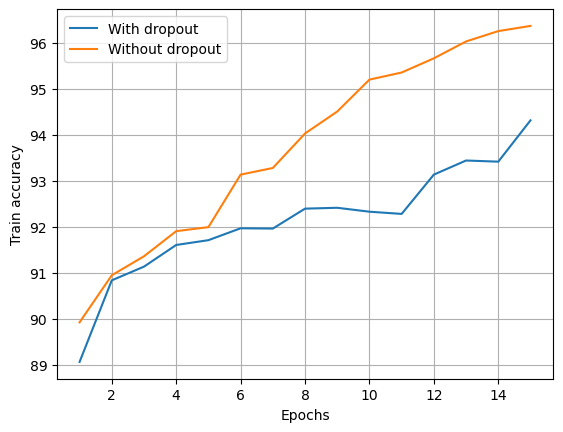

In [117]:
epochs = torch.arange(1,16,1)

plt.plot(epochs, train_acc_cnn_do, label='With dropout')
plt.plot(epochs, train_acc_cnn, label='Without dropout')
plt.xlabel('Epochs')
plt.ylabel('Train accuracy')
plt.grid()
plt.legend()
plt.show()